## Part 5: Machine learning on graphs

### 5.1 Representation learning

In [1]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from utils.functions import draw_network
from node2vec import Node2Vec
np.random.seed(42)

The derived graph Gder_resource (connected nodes share at least one common resource) is imported and visualised.

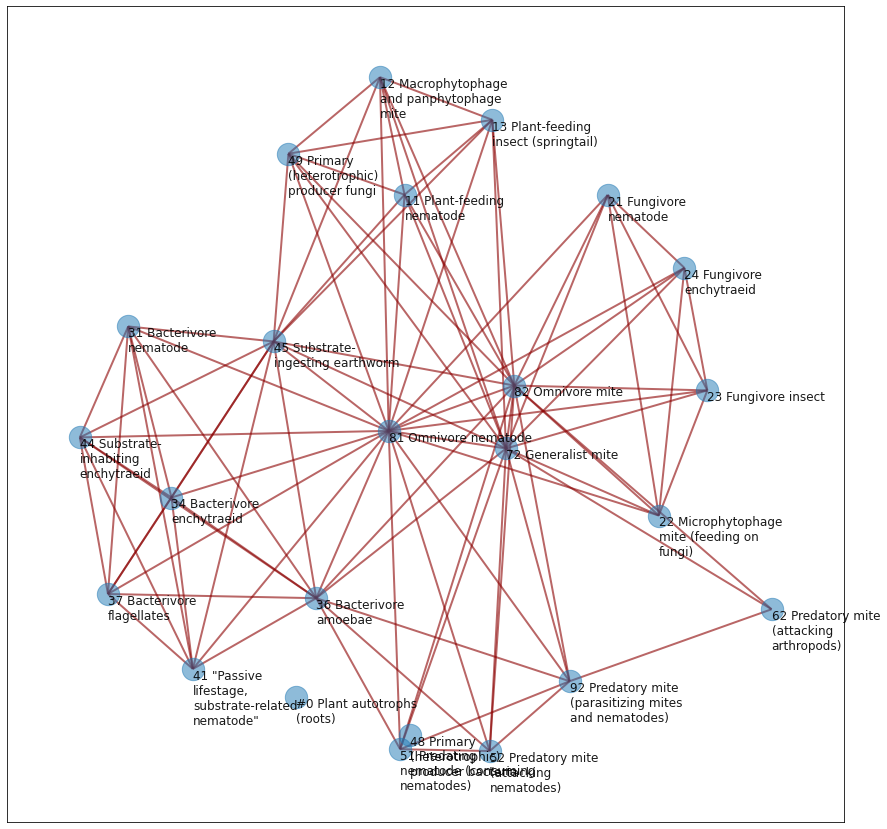

In [2]:
#G = nx.read_gpickle("results/G.pickle")
#G = nx.Graph(G)
#G = nx.read_gpickle("results/Gder_consumer.pickle")
G = nx.read_gpickle("results/Gder_resource.pickle")
trophic_levels = pd.read_pickle('results/trophic_levels.pickle')

# visualise derived network
fig, ax = plt.subplots(figsize=(15, 15))
draw_network(G, ax)

Continuous feature vectors (embeddings) of the networks' nodes are learned with the node2vec algorithm that maps the nodes to a low-dimensional space of features that maximizes the likelihood of preserving network neighborhoods of nodes (Grover & Leskovec 2016).

keep workers at 1 to have reproducibility.

#### 5.1.1 Node2Vec

In [3]:
node2vec = Node2Vec(G, dimensions=5, walk_length=15, num_walks=100, workers=1)  
model = node2vec.fit(window=5, min_count=1, seed=42)

Computing transition probabilities:   0%|          | 0/24 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|████████████████████████| 100/100 [00:00<00:00, 687.16it/s]


With the obtained embeddings of nodes it is possible to calculate the distance between points in the vector space. As an example, a search for the most similar node to the one given is performed. 

First, with a node from trophic level 0.

In [4]:
model.wv.most_similar('#0 Plant autotrophs (roots)',  topn=3)

[('44 Substrate-inhabiting enchytraeid', -0.19811198115348816),
 ('22 Microphytophage mite (feeding on fungi)', -0.24248655140399933),
 ('23 Fungivore insect', -0.24848760664463043)]

Second, with a node from trophic level 3.

In [5]:
model.wv.most_similar('72 Generalist mite', topn=3)

[('82 Omnivore mite', 0.9788652062416077),
 ('11 Plant-feeding nematode', 0.9586005210876465),
 ('49 Primary (heterotrophic) producer fungi', 0.940077543258667)]

To obain a matrix with the node embeddings the node vectors are extracted and stored in an array. The vectors' values are normalised and dimensionality reduction is performed with UMAP.

In [136]:
from sklearn.preprocessing import StandardScaler
import umap

node_embeddings = np.array([model.wv.get_vector(node) for node in model.wv.key_to_index])
node_names = [node for node in model.wv.key_to_index]

scaled_array = StandardScaler().fit_transform(node_embeddings)
scaled_df = pd.DataFrame(scaled_array)

# 1D embedding
reducer = umap.UMAP(n_components=1, random_state=123) #n_neighbors=5, min_dist=0.5, metric="euclidean"
node_embeddings_1D = reducer.fit_transform(scaled_df)

# 2D embedding
reducer = umap.UMAP(n_components=2, random_state=123) #n_neighbors=5, min_dist=0.5, metric="euclidean"
node_embeddings_2D = reducer.fit_transform(scaled_df)

The node embeddings can be visualised in 1D space.

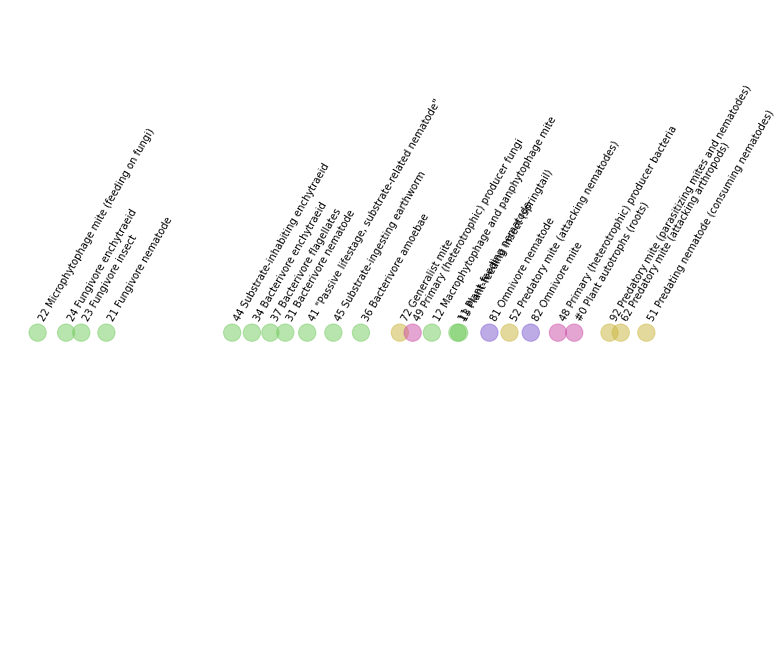

In [139]:
import textwrap
from utils.functions import get_colors

trophic_level_dict = trophic_levels.to_dict()

if len(set(trophic_level_dict.values())) <= 5:
    colors = ["#cb4da6", "#72ca5e", "#7d58cf", "#cbb53c", "#cf4f3e"]
else:
    colors = get_colors(len(set(trophic_level_dict.values())))
node_colors = [colors[trophic_level_dict[node_name]] for node_name in node_names]

x = node_embeddings_1D[:,0]
y = [1] * len(x)

figure = plt.figure(figsize=(12, 12))
_ = plt.scatter(x, y, c=node_colors, marker = "o", s=300, alpha=0.5)
_ = plt.axis('off')

for i, xy in enumerate(zip(x, y)):
    label = '\n'.join(textwrap.wrap(node_names[i], 30, break_long_words=True))
    plt.annotate(node_names[i], (xy[0], xy[1] + 0.002), fontsize=10, rotation=60)
    
plt.savefig('results/figures/1D_embedding.png')

Node embeddings visualised in 2D space.

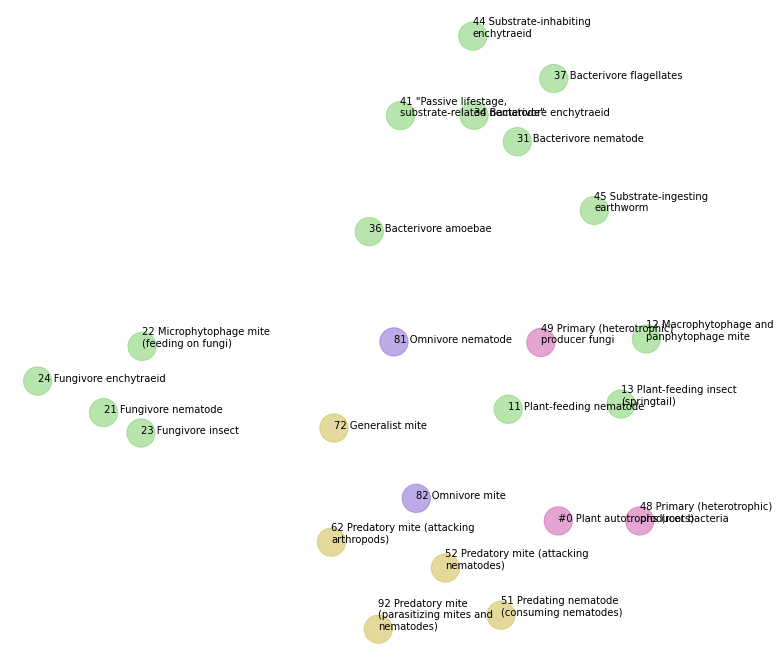

In [138]:
import textwrap
from utils.functions import get_colors

trophic_level_dict = trophic_levels.to_dict()

if len(set(trophic_level_dict.values())) <= 5:
    colors = ["#cb4da6", "#72ca5e", "#7d58cf", "#cbb53c", "#cf4f3e"]
else:
    colors = get_colors(len(set(trophic_level_dict.values())))
node_colors = [colors[trophic_level_dict[node_name]] for node_name in node_names]

x = node_embeddings_2D[:,0]
y = node_embeddings_2D[:,1]

figure = plt.figure(figsize=(12, 12))
_ = plt.scatter(x, y, c=node_colors, s=800, alpha=0.5)
_ = plt.axis('off')

for i, xy in enumerate(zip(x, y)):
    label = '\n'.join(textwrap.wrap(node_names[i], 30, break_long_words=True))
    plt.annotate(label, (xy[0], xy[1]), fontsize=10)

The figure summarises the derived network that was projected in 2D space. The node colors are random and represent the trophic levels. The results revela that certain trophic groups with common resources are closer in space, which is in line with their position in the network. The same could be done with the other derived network, which is less suitable for this task as it is much more connected and the graph itslef shows, which nodes are similar.